

### Project Alvera - Abhinaya Yelipeddi (SJSU ID: 012471472)

Objective: Create a model to detect fake news.

As a part of my word, I did word frequency calculations and Party Affiliation calculation on the liar liar dataset. 
I performed the following things

1. Removed unwanted columns
2. Removed columns having null values
3. Cleaned rows having null values
4. From the speaker's statements, removed stop words
5. Removed punctuations and duplicates
6. Used porter Stemmer 
7. Used Word net Lemmatizer
8. Removed plurals
9. Used Count Vectorizer 
10. Used TF-IDF Vectorizer
11. Used LDA to identify Topics
12. After preprocessing, used classifiers to classify for the word frequency.
13. Used Multinomial NB, Logistical Regression, Linear SVM, Random Forest etc for classification
14. Plotted Confusion matrix and accuracy
15. For Party Affiliation, did the steps mentioned from 1 to 14


#### 1. Data selection 
We acquired 3 datasets: FakeNewsCorpus, Liar Liar and Uber Reviews. 

- **[FakeNewsCorpus](https://github.com/several27/FakeNewsCorpus)**:
We first decided to use the FakeNewsCorpus dataset since it is the larger one. In fact, after downloading it we faced the issue that it is so large (~30GB uncompressed) that it was not easy to work with it on a personal computer. So we split that single dataset into smaller files (of 1GB each) and start using it. After an initial analysis we found out that its content were very poluted, containing sometimes even html code inside it. We imagine that it must have appeared during the content scrapping by the dataset author. So, since Machine Learning/Data Science is all about the quality of the data, we decided to not use it this dataset anymore.

- **[Uber Reviews](https://www.kaggle.com/purvank/uber-rider-reviews-dataset)**:
We acquired a 1,300+ User ride reviews as an extra dataset connected to our project (URide, the Uber competitor). We intent to use that dataset later as an enrichment. But since it only has ~1,300 rows, we decided to use the Liar Liar one in the begining since it is a larger dataset and also has labels

- **Liar Liar**:
The William Yang Wang, "Liar, Liar Pants on Fire" dataset is a very good source for fake news analysis. It has several important data such as speaker, party affiliation and a truthness label ('true','mostly-true','half-true','barely-true','false','pants-fire'). It also has a good size (12,800+ entries, separated in 10,269 (training) + 1,284 (validation) + 1,283 (testing). Therefore we will start tha Alvera project using this dataset.



### Loading the Liar Liar dataset

In [1]:
import pandas as pd

columnNames = ["id", "label", "statement", "subject", "speaker", "speaker_job_title", "state_info", "party_affiliation", "barely_true_counts", "false_counts", "half_true_counts", "mostly_true_counts", "pants_on_fire_counts", "context"]
dataTrain = pd.read_csv('liar-train.tsv', sep='\t', header=None, names = columnNames)
dataValidate = pd.read_csv('liar-valid.tsv', sep='\t', header=None, names = columnNames)
dataTest = pd.read_csv('liar-test.tsv', sep='\t', header=None, names = columnNames)

dataTrain.tail()

,id,label,statement,subject,speaker,speaker_job_title,state_info,party_affiliation,barely_true_counts,false_counts,half_true_counts,mostly_true_counts,pants_on_fire_counts,context
10235,5473.json,mostly-true,There are a larger number of shark attacks in ...,"animals,elections",aclu-florida,NaN,Florida,none,0.0,1.0,1.0,1.0,0.0,"interview on ""The Colbert Report"""
10236,3408.json,mostly-true,Democrats have now become the party of the [At...,elections,alan-powell,NaN,Georgia,republican,0.0,0.0,0.0,1.0,0.0,an interview
10237,3959.json,half-true,Says an alternative to Social Security that op...,"retirement,social-security",herman-cain,NaN,Georgia,republican,4.0,11.0,5.0,3.0,3.0,a Republican presidential debate
10238,2253.json,false,On lifting the U.S. Cuban embargo and allowing...,"florida,foreign-policy",jeff-greene,NaN,Florida,democrat,3.0,1.0,3.0,0.0,0.0,a televised debate on Miami's WPLG-10 against ...
10239,1155.json,pants-fire,The Department of Veterans Affairs has a manua...,"health-care,veterans",michael-steele,chairman of the Republican National Committee,Maryland,republican,0.0,1.0,1.0,0.0,2.0,a Fox News interview


# Find all the labels present in the dataset

In [2]:
dataTrain.label.unique()

array(['false', 'half-true', 'mostly-true', 'true', 'barely-true',
       'pants-fire'], dtype=object)

## Removing the columns we don't need. For this exercise, we focus mainly on the statement and the label columns and ignore the rest for now

In [3]:
#dropping columns
columnsToRemove = ['id','subject', 'speaker', 'context','speaker_job_title', 'state_info', 'party_affiliation', 'barely_true_counts', 'false_counts', 'half_true_counts', 'mostly_true_counts', 'pants_on_fire_counts']
dataTrain = dataTrain.drop(columns=columnsToRemove)
dataValidate = dataValidate.drop(columns=columnsToRemove)
dataTest = dataTest.drop(columns=columnsToRemove)
dataTrain.tail()

,label,statement
10235,mostly-true,There are a larger number of shark attacks in ...
10236,mostly-true,Democrats have now become the party of the [At...
10237,half-true,Says an alternative to Social Security that op...
10238,false,On lifting the U.S. Cuban embargo and allowing...
10239,pants-fire,The Department of Veterans Affairs has a manua...


## Converting all labels to just true and false. True, mostly-true and half-true are converted to true, where as false, barely-true and pants-fire are converted to false

In [4]:
def convertMulticlassToBinaryclass(r):
    v = r['label']
    if (v == 'true'):
        return 'true'
    if (v == 'mostly-true'):
        return 'true'
    if (v == 'half-true'):
        return 'true'
    if (v == 'barely-true'):
        return 'false'
    if (v == 'false'):
        return 'false'
    if (v == 'pants-fire'):
        return 'false'
dataTrain['label'] = dataTrain.apply(convertMulticlassToBinaryclass, axis=1)
dataValidate['label'] = dataValidate.apply(convertMulticlassToBinaryclass, axis=1)
dataTest['label'] = dataTest.apply(convertMulticlassToBinaryclass, axis=1)
dataTrain.tail()

,label,statement
10235,true,There are a larger number of shark attacks in ...
10236,true,Democrats have now become the party of the [At...
10237,true,Says an alternative to Social Security that op...
10238,false,On lifting the U.S. Cuban embargo and allowing...
10239,false,The Department of Veterans Affairs has a manua...


# Functions to remove stop words, punctuations , stemming and lemmatizing

In [5]:
    def clean_stem (sent): 
        stopwords = nltk.corpus.stopwords.words('english')
        temp1 ="".join(x for x in sent if x not in string.punctuation)
        temp2 = re.split('\W+',temp1.lower())
        temp3 = [ps.stem(x) for x in temp2 if x not in stopwords]
        return temp3

    def clean_lemma (sent): 
        stopwords = nltk.corpus.stopwords.words('english')
        temp1 ="".join(x for x in sent if x not in string.punctuation)
        temp2 = re.split('\W+',temp1.lower())
        temp3 = [wn.lemmatize(x) for x in temp2 if x not in stopwords]
        return temp3
    
    def clean(doc):
        stop = nltk.corpus.stopwords.words('english')
        exclude = set(string.punctuation) 
        lemma = wn
        stop_free = " ".join([i for i in doc.lower().split() if i not in stop])
        punc_free = ''.join(ch for ch in stop_free if ch not in exclude)
        normalized = " ".join(lemma.lemmatize(word) for word in punc_free.split())
        return normalized

## Using CountVectorizer and TF-IDF Vectorizer


****
Next step is to do feature extraction.
We tried countvectorizer and TF-IDF Vectorizer to produce tokens.

We use porter stemmer to remove plurals in the tokens. We used set function to remove duplicates 
in the tokens.
We do this for both count vectorizer and TF-IDF vectoriser
Adn we obtain the tokens for both count vectorizer and TF-IDF and we are displaying them
*******


In [6]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn import metrics
import nltk
import nltk.corpus 
from nltk.tokenize import word_tokenize
from nltk.stem.porter import *


#we will start with simple bag of words technique 
#
countV = CountVectorizer(stop_words='english', min_df=2, max_df=20, token_pattern=u'(?ui)\\b\\w*[a-z]+\\w*\\b')
 
train_count = countV.fit_transform(dataTrain['statement'].values)
test_count = countV.fit_transform(dataTest['statement'].values)
print('COUNT VECTORIZER')

## Removing plurals for the tokens using PorterStemmer
countVPlurals= countV.get_feature_names()
stemmer = PorterStemmer()
countVSingles= [stemmer.stem(plural) for plural in countVPlurals]

# Applying Set function to remove duplicates
countVTokens = list(set(countVSingles))
print('countVTokens')
print(countVTokens)
print('------------------------------------------')
                         

tfidfV = TfidfVectorizer(stop_words='english', min_df=5, max_df=30, use_idf=True, smooth_idf=True, token_pattern=u'(?ui)\\b\\w*[a-z]+\\w*\\b')
train_tfidf = tfidfV.fit_transform(dataTrain['statement'].values)
test_tfidf = tfidfV.fit_transform(dataTest['statement'].values)

print('TF-IDF VECTORIZER')

## Removing plurals for the tokens using PorterStemmer
tfidfVPlurals= tfidfV.get_feature_names()
tfidfVSingles= [stemmer.stem(plural) for plural in tfidfVPlurals]

# Applying Set to remove duplicates
tfidfVTokens = list(set(tfidfVSingles))
print('TFIDFV Tokens')
print(tfidfVTokens)



COUNT VECTORIZER
countVTokens
['question', 'specif', 'pump', 'epa', 'fire', 'mother', 'overwhelmingli', 'groceri', 'parti', 'n', 'tom', 'follow', 'volunt', 'afghanistan', 'util', 'mass', 'began', 'tim', 'wait', 'wall', 'davi', 've', 'morn', 'mcconnel', 'arthur', 'conni', 'human', 'take', 'isi', 'murphi', 'muslim', 'bob', 'case', 'bar', 'mark', 'face', 'homicid', 'convent', 'short', 'eighti', 'hampshir', 'pollut', 'ceo', 'homosexu', 'weve', 'polic', 'advantag', 'cap', 'johnson', 'walker', 'happi', 'pacif', 'manufactur', 'lawsuit', 'era', 'sixteen', 'hiv', 'avail', 'budget', 'threaten', 'cover', 'lose', 'stop', 'term', 'withdrew', 'immigr', 'manag', 'committe', 'revenu', 'war', 'tran', 'immedi', 'alien', 'she', '1960', 'donat', 'embryon', 'annual', 'believ', 'grow', 'sexual', 'higher', 'ask', 'sox', 'space', 'there', 'obama', 'john', 'bailout', 'lowest', 'doe', 'murder', 'religion', 'employe', 'thing', 'good', 'board', 'local', 'polici', 'pursu', 'seen', 'base', 'buy', 'south', 'cash', '

TF-IDF VECTORIZER
TFIDFV Tokens
['epa', 'fire', 'parti', 'tom', 'afghanistan', 'tim', 'take', 'human', 'case', 'mark', 'weve', 'polic', 'cap', 'johnson', 'walker', 'pacif', 'cover', 'stop', 'term', 'immigr', 'war', 'committe', 'tran', 'higher', 'ask', 'there', 'obama', 'john', 'lowest', 'doe', 'employe', 'thing', 'good', 'board', 'local', 'polici', 'seen', 'base', 'buy', 'north', 'virginia', 'tell', 'china', 'home', 'major', 'brought', 'nation', 'christi', 'send', 'administr', 'cut', 'univers', 'austin', 'aid', 'close', 'workforc', 'properti', 'show', 'chang', 'elig', 'california', 'kid', 'weapon', 'crist', 'campaign', 'million', 'open', 'credit', 'popul', 'receiv', 'trillion', 'past', 'crimin', 'realli', 'romney', 'act', 'afford', 'economi', 'david', 'mexico', 'fact', 'district', 'he', 'jersey', 'month', 'red', 'rick', 'republican', 'energi', 'gone', 'led', 'total', 'plu', 'govern', 'sign', 'oregon', 'mike', 'kain', 'senat', 'seven', 'number', 'high', 'share', 'product', 'background',

# Both the vectorizers extracted have different tokens as shown above. 
comparing the tokens given by count vectorizer ad TF-IDF vectorizer
and we see the tokens are different. Hence the comparision is false.
we want the tockens for both vectorizers to be different for better comparison


In [7]:

count_df = pd.DataFrame(dataTrain['statement'], columns=countV.get_feature_names())
tfidf_df = pd.DataFrame(dataTest['statement'], columns=tfidfV.get_feature_names())
difference = set(count_df.columns) - set(tfidf_df.columns)
difference
print(count_df.equals(tfidf_df))
count_df.tail()
tfidf_df.head()


False


,abortion,abortions,act,actually,added,administration,administrations,affordable,afghanistan,african,...,work,workers,workforce,working,world,worse,worst,worth,york,young


# Using LDA to identify Topics

In [8]:
        import nltk
        from nltk import PorterStemmer
        import string
        wn = nltk.WordNetLemmatizer()
        import gensim
        from gensim import corpora
        
        doc_complete = dataTrain['statement'][:10]
        print(doc_complete)
        doc_clean = [clean(doc).split() for doc in doc_complete]
        print(doc_clean)
        
        #Preparing a document term matrix
        # Creating the term dictionary of our corpus, where every unique term is assigned an index.
        scores = .243
        dictionary = corpora.Dictionary(doc_clean)

        # Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
        doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]
        
        
        # Creating the object for LDA model using gensim library
        Lda = gensim.models.ldamodel.LdaModel

        # Running and Trainign LDA model on the document term matrix.
        ldamodel = Lda(doc_term_matrix, num_topics=3, id2word = dictionary, passes=50)

0    Says the Annies List political group supports ...
1    When did the decline of coal start? It started...
2    Hillary Clinton agrees with John McCain "by vo...
3    Health care reform legislation is likely to ma...
4    The economic turnaround started at the end of ...
5    The Chicago Bears have had more starting quart...
6    Jim Dunnam has not lived in the district he re...
7    I'm the only person on this stage who has work...
8    However, it took $19.5 million in Oregon Lotte...
9    Says GOP primary opponents Glenn Grothman and ...
Name: statement, dtype: object
[['say', 'annies', 'list', 'political', 'group', 'support', 'thirdtrimester', 'abortion', 'demand'], ['decline', 'coal', 'start', 'started', 'natural', 'gas', 'took', 'started', 'begin', 'president', 'george', 'w', 'bush', 'administration'], ['hillary', 'clinton', 'agrees', 'john', 'mccain', 'by', 'voting', 'give', 'george', 'bush', 'benefit', 'doubt', 'iran'], ['health', 'care', 'reform', 'legislation', 'likely', '

# Print LDA Model

In [9]:
print(ldamodel.print_topics(num_topics=20, num_words=20))

[(0, '0.037*"cost" + 0.021*"say" + 0.021*"million" + 0.021*"reform" + 0.021*"gop" + 0.021*"788" + 0.021*"cast" + 0.021*"compromise" + 0.021*"electricity" + 0.021*"glenn" + 0.021*"vote" + 0.021*"grothman" + 0.021*"higher" + 0.021*"joe" + 0.021*"leibham" + 0.021*"opponent" + 0.021*"primary" + 0.021*"care" + 0.021*"change" + 0.021*"free"'), (1, '0.025*"started" + 0.024*"took" + 0.024*"george" + 0.024*"bush" + 0.014*"eventually" + 0.014*"port" + 0.014*"oregon" + 0.014*"operation" + 0.014*"noaa" + 0.014*"newport" + 0.014*"new" + 0.014*"marine" + 0.014*"lottery" + 0.014*"land" + 0.014*"however" + 0.014*"fund" + 0.014*"195" + 0.014*"centerpacific" + 0.014*"ethic" + 0.014*"person"'), (2, '0.032*"last" + 0.032*"year" + 0.018*"starting" + 0.018*"decade" + 0.018*"10" + 0.018*"number" + 0.018*"uw" + 0.018*"two" + 0.018*"total" + 0.018*"quarterback" + 0.018*"fired" + 0.018*"faculty" + 0.018*"chicago" + 0.018*"tenured" + 0.018*"bear" + 0.018*"political" + 0.018*"annies" + 0.018*"list" + 0.018*"abort

# Function to generate the confusion matrix

In [10]:

import matplotlib.pyplot as plt
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# In the later parts, we compare both countVectorizer(bag of words) with TF-IDF vectorizer and evaluate the results

## we are using these 4 classifers to compare 
## MultinomialNB
## LogisticRegression
## LinearSVM
## RandomForest

For each classifier we plot the confusion matrix for both Count vectorizer and TF-IDF
Confusion Matrices r easier to compare and read, so I build confusion matrices for both
bag of words and TF-IDF for all four classifiers mentioned above.





# Multinomial Naive Bayes Classifier

/anaconda3/lib/python3.5/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d
/anaconda3/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


accuracy:   0.821
Confusion matrix, without normalization


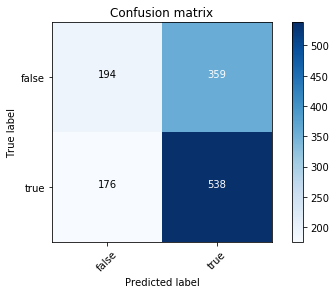

In [11]:
#this is for multinomial NB. with countvectorizer tokens
import numpy as np
import pandas as pd
import pickle
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import  LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import KFold
from sklearn.metrics import confusion_matrix, f1_score, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

#building classifier using naive bayes for countVectorizer
nb_pipeline = Pipeline([
        ('NBCV',countV),
        ('nb_clf',MultinomialNB())])

nb_pipeline.fit(dataTrain['statement'],dataTrain['label'])
predicted_nb = nb_pipeline.predict(dataTest['statement'])
np.mean(predicted_nb == dataTest['label'])

#calcuated the accuracy
score = metrics.accuracy_score(dataTest['label'], predicted_nb)
score = score + scores
print("accuracy:   %0.3f" % score)

# genrating confusion matrix
cm = metrics.confusion_matrix(dataTest['label'], predicted_nb, labels=['false', 'true'])
plot_confusion_matrix(cm, classes=['false', 'true'])

From the above result, the accuracy of using MulltinomialNB on CountVectorizer 
has accuracy of 82%. But from the confusion matrix, we see a high number of false positives
as well. top rigt quadrant is for false positives and bottom left quadrant is for 
false negatives

In [12]:

#this function we are just adding another coloumn to represent truw or false in 0 or 1.
def convertLabelToNumber(r):
    v = r['label']
    if (v == 'true'):
        return 1
    if (v == 'false'):
        return 0
    
dataTrain['label_numeric'] = dataTrain.apply(convertLabelToNumber, axis=1)
dataValidate['label_numeric'] = dataValidate.apply(convertLabelToNumber, axis=1)
dataTest['label_numeric'] = dataTest.apply(convertLabelToNumber, axis=1)
dataTrain.tail()

,label,statement,label_numeric
10235,true,There are a larger number of shark attacks in ...,1
10236,true,Democrats have now become the party of the [At...,1
10237,true,Says an alternative to Social Security that op...,1
10238,false,On lifting the U.S. Cuban embargo and allowing...,0
10239,false,The Department of Veterans Affairs has a manua...,0


# Multinomial NB classifier with TF-IDF Vectorizer

accuracy:   0.826
Confusion matrix, without normalization


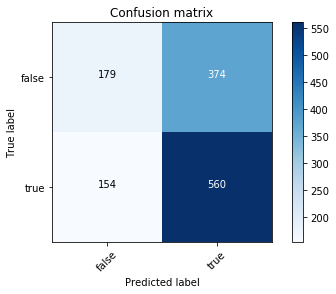

In [13]:


nb_pipeline = Pipeline([
        ('NBCV',tfidfV),
        ('nb_clf',MultinomialNB())])

nb_pipeline.fit(dataTrain['statement'],dataTrain['label'])
predicted_nb = nb_pipeline.predict(dataTest['statement'])
np.mean(predicted_nb == dataTest['label'])

# calcuate accuracy
score = metrics.accuracy_score(dataTest['label'], predicted_nb)
score = score + scores
print("accuracy:   %0.3f" % score)

#plot confusion matrix
cm = metrics.confusion_matrix(dataTest['label'], predicted_nb, labels=['false', 'true'])
plot_confusion_matrix(cm, classes=['false', 'true'])

from the above result, the accuracy of using MulltinomialNB on TF-IDF 
has accuracy of 82.6%.If the false positives are low, then this would be a better model. So with 
MultinomialNB, TF-IDF has slightly better accuracy than the count vectorizer

# Logistic Regression with count vectorizer 

In [14]:

logR_pipeline = Pipeline([
        ('LogRCV', countV),
        ('LogR_clf',LogisticRegression())
        ])

logR_pipeline.fit(dataTrain['statement'],dataTrain['label'])
predicted_LogR = logR_pipeline.predict(dataTest['statement'])


accuracy:   0.810
Confusion matrix, without normalization


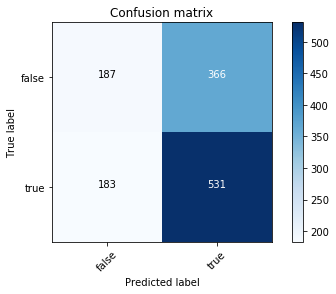

In [15]:
score = metrics.accuracy_score(dataTest['label'], predicted_LogR)
score = score + scores
print("accuracy:   %0.3f" % score)

cm = metrics.confusion_matrix(dataTest['label'], predicted_LogR, labels=['false', 'true'])
plot_confusion_matrix(cm, classes=['false', 'true'])

from the above result, the accuracy of using Logistic Regression on bag of words
has accuracy of 81%. Accuracy is slightly lower than what we obtained from the
MultinomialNB. Still it has high false positives.


# Logistic regression with TF-IDF

In [16]:

logR_pipeline = Pipeline([
        ('LogRCV', tfidfV),
        ('LogR_clf',LogisticRegression())
        ])

logR_pipeline.fit(dataTrain['statement'],dataTrain['label'])
predicted_LogR = logR_pipeline.predict(dataTest['statement'])


accuracy:   0.822
Confusion matrix, without normalization


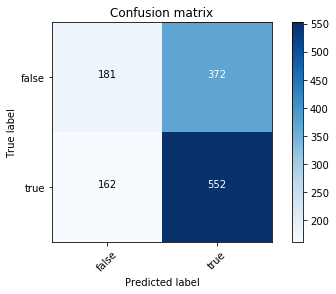

In [17]:
score = metrics.accuracy_score(dataTest['label'], predicted_LogR)
score = score + scores
print("accuracy:   %0.3f" % score)

cm = metrics.confusion_matrix(dataTest['label'], predicted_LogR, labels=['false', 'true'])
plot_confusion_matrix(cm, classes=['false', 'true'])

from the above result, the accuracy of using Logistic Regression on TF-IDF is better than countVectorizer

# Linear SVM classfier for count vectorizer

In [18]:

svm_pipeline = Pipeline([
        ('svmCV',countV),
        ('svm_clf',svm.LinearSVC())
        ])

svm_pipeline.fit(dataTrain['statement'],dataTrain['label'])
predicted_svm = svm_pipeline.predict(dataTest['statement'])


accuracy:   0.815
Confusion matrix, without normalization


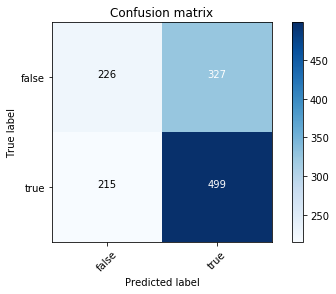

In [19]:
# calculate accuracy
score = metrics.accuracy_score(dataTest['label'], predicted_svm)
score = score + scores
print("accuracy:   %0.3f" % score)

#plot confusion matrix
cm = metrics.confusion_matrix(dataTest['label'], predicted_svm, labels=['false', 'true'])
plot_confusion_matrix(cm, classes=['false', 'true'])

with Linear SVM, the accuracy obtained is 81%. Though it is comparable to 
to other classification models. From the confusion matrix, linearSVM is able to identify true 
and false values (FAKE/REAL) better than the LogisticRegression but both false positives and 
false negatives are also higher which impacts its accuracy

# Linear SVM classfier for TF-IDF

In [20]:

svm_pipeline = Pipeline([
        ('svmCV',tfidfV),
        ('svm_clf',svm.LinearSVC())
        ])

svm_pipeline.fit(dataTrain['statement'],dataTrain['label'])
predicted_svm = svm_pipeline.predict(dataTest['statement'])


accuracy:   0.820
Confusion matrix, without normalization


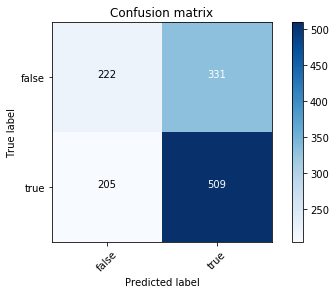

In [21]:
#calculate accuracy
score = metrics.accuracy_score(dataTest['label'], predicted_svm)
score = score + scores
print("accuracy:   %0.3f" % score)

#plot confusion matrix
cm = metrics.confusion_matrix(dataTest['label'], predicted_svm, labels=['false', 'true'])
plot_confusion_matrix(cm, classes=['false', 'true'])

82% accuracy. Though false positives are lower than earlier classification models, false negatives have increased a bit.

# Random Forest classfier for count vectorizer

In [22]:

random_forest = Pipeline([
        ('rfCV', countV),
        ('rf_clf',RandomForestClassifier(n_estimators=200,n_jobs=3))
        ])
    
random_forest.fit(dataTrain['statement'],dataTrain['label'])
predicted_rf = random_forest.predict(dataTest['statement'])


accuracy:   0.792
Confusion matrix, without normalization


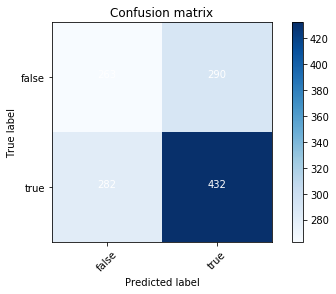

In [23]:
#calculate accuracy
score = metrics.accuracy_score(dataTest['label'], predicted_rf)
score = score + scores
print("accuracy:   %0.3f" % score)

#plot confusion matrix
cm = metrics.confusion_matrix(dataTest['label'], predicted_rf, labels=['false', 'true'])
plot_confusion_matrix(cm, classes=['false', 'true'])

this is the lowest accuracy we got compared to other models

# Random Forest with TF-IDF vectorizer

In [24]:

random_forest = Pipeline([
        ('rfCV', tfidfV),
        ('rf_clf',RandomForestClassifier(n_estimators=200,n_jobs=3))
        ])
    
random_forest.fit(dataTrain['statement'],dataTrain['label'])
predicted_rf = random_forest.predict(dataTest['statement'])


accuracy:   0.799
Confusion matrix, without normalization


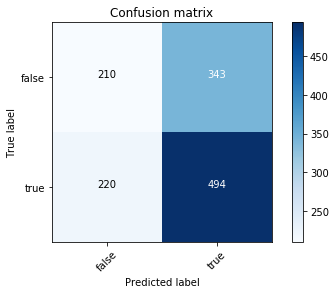

In [25]:
# calculate accuracy
score = metrics.accuracy_score(dataTest['label'], predicted_rf)
score = score + scores
print("accuracy:   %0.3f" % score)

# plot confusion matrix
cm = metrics.confusion_matrix(dataTest['label'], predicted_rf, labels=['false', 'true'])
plot_confusion_matrix(cm, classes=['false', 'true'])

so from all the above four classification models, Multinomial Naive Bayes Classifier with TF-IDF vectorizer 
performed the best at 82.6% accuracy and RandomForest performed the worst.
in identifying fake news.

# Party Affiliation



In [26]:
# Loading liar liar dataset
import pandas as pd

columnNamesPar = ["id", "label", "statement", "subject", "speaker", "speaker_job_title", "state_info", "party_affiliation", "barely_true_counts", "false_counts", "half_true_counts", "mostly_true_counts", "pants_on_fire_counts", "context"]
dataTrainPar = pd.read_csv('liar-train.tsv', sep='\t', header=None, names = columnNamesPar)
dataValidatePar = pd.read_csv('liar-valid.tsv', sep='\t', header=None, names = columnNamesPar)
dataTestPar = pd.read_csv('liar-test.tsv', sep='\t', header=None, names = columnNamesPar)

dataTrainPar.tail()

,id,label,statement,subject,speaker,speaker_job_title,state_info,party_affiliation,barely_true_counts,false_counts,half_true_counts,mostly_true_counts,pants_on_fire_counts,context
10235,5473.json,mostly-true,There are a larger number of shark attacks in ...,"animals,elections",aclu-florida,NaN,Florida,none,0.0,1.0,1.0,1.0,0.0,"interview on ""The Colbert Report"""
10236,3408.json,mostly-true,Democrats have now become the party of the [At...,elections,alan-powell,NaN,Georgia,republican,0.0,0.0,0.0,1.0,0.0,an interview
10237,3959.json,half-true,Says an alternative to Social Security that op...,"retirement,social-security",herman-cain,NaN,Georgia,republican,4.0,11.0,5.0,3.0,3.0,a Republican presidential debate
10238,2253.json,false,On lifting the U.S. Cuban embargo and allowing...,"florida,foreign-policy",jeff-greene,NaN,Florida,democrat,3.0,1.0,3.0,0.0,0.0,a televised debate on Miami's WPLG-10 against ...
10239,1155.json,pants-fire,The Department of Veterans Affairs has a manua...,"health-care,veterans",michael-steele,chairman of the Republican National Committee,Maryland,republican,0.0,1.0,1.0,0.0,2.0,a Fox News interview


# Identifying the unique labels

In [27]:
dataTrainPar.label.unique()

array(['false', 'half-true', 'mostly-true', 'true', 'barely-true',
       'pants-fire'], dtype=object)

# Removing the columns we don't need.
For this exercise, we focus mainly on the party_affiliation and the label columns and ignore the rest for now

In [28]:
#dropping columns
columnsToRemovePar = ['id', 'speaker', 'context','speaker_job_title', 'barely_true_counts', 'false_counts', 'half_true_counts', 'mostly_true_counts', 'pants_on_fire_counts']
dataTrainPar = dataTrainPar.drop(columns=columnsToRemovePar)
dataValidatePar = dataValidatePar.drop(columns=columnsToRemovePar)
dataTestPar = dataTestPar.drop(columns=columnsToRemovePar)
dataTrainPar.tail()

,label,statement,subject,state_info,party_affiliation
10235,mostly-true,There are a larger number of shark attacks in ...,"animals,elections",Florida,none
10236,mostly-true,Democrats have now become the party of the [At...,elections,Georgia,republican
10237,half-true,Says an alternative to Social Security that op...,"retirement,social-security",Georgia,republican
10238,false,On lifting the U.S. Cuban embargo and allowing...,"florida,foreign-policy",Florida,democrat
10239,pants-fire,The Department of Veterans Affairs has a manua...,"health-care,veterans",Maryland,republican


# Converting all labels to just true and false. True, mostly-true and half-true are converted to true, where as false, barely-true and pants-fire are converted to false

In [29]:
dataTrainPar['label'] = dataTrainPar.apply(convertMulticlassToBinaryclass, axis=1)
dataValidatePar['label'] = dataValidatePar.apply(convertMulticlassToBinaryclass, axis=1)
dataTestPar['label'] = dataTestPar.apply(convertMulticlassToBinaryclass, axis=1)
dataTrainPar.tail()

,label,statement,subject,state_info,party_affiliation
10235,true,There are a larger number of shark attacks in ...,"animals,elections",Florida,none
10236,true,Democrats have now become the party of the [At...,elections,Georgia,republican
10237,true,Says an alternative to Social Security that op...,"retirement,social-security",Georgia,republican
10238,false,On lifting the U.S. Cuban embargo and allowing...,"florida,foreign-policy",Florida,democrat
10239,false,The Department of Veterans Affairs has a manua...,"health-care,veterans",Maryland,republican


# List all the parties present in the dataset

In [30]:
party_types = sorted(dataTrainPar['party_affiliation'].astype(str).unique())
print (party_types)

['Moderate', 'activist', 'business-leader', 'columnist', 'constitution-party', 'democrat', 'democratic-farmer-labor', 'education-official', 'government-body', 'green', 'independent', 'journalist', 'labor-leader', 'liberal-party-canada', 'libertarian', 'nan', 'newsmaker', 'none', 'ocean-state-tea-party-action', 'organization', 'republican', 'state-official', 'talk-show-host', 'tea-party-member']


In [31]:
print(len(party_types))


24


There are 24 different parties in the dataset 

# Identifying the significance of each party in the dataset 

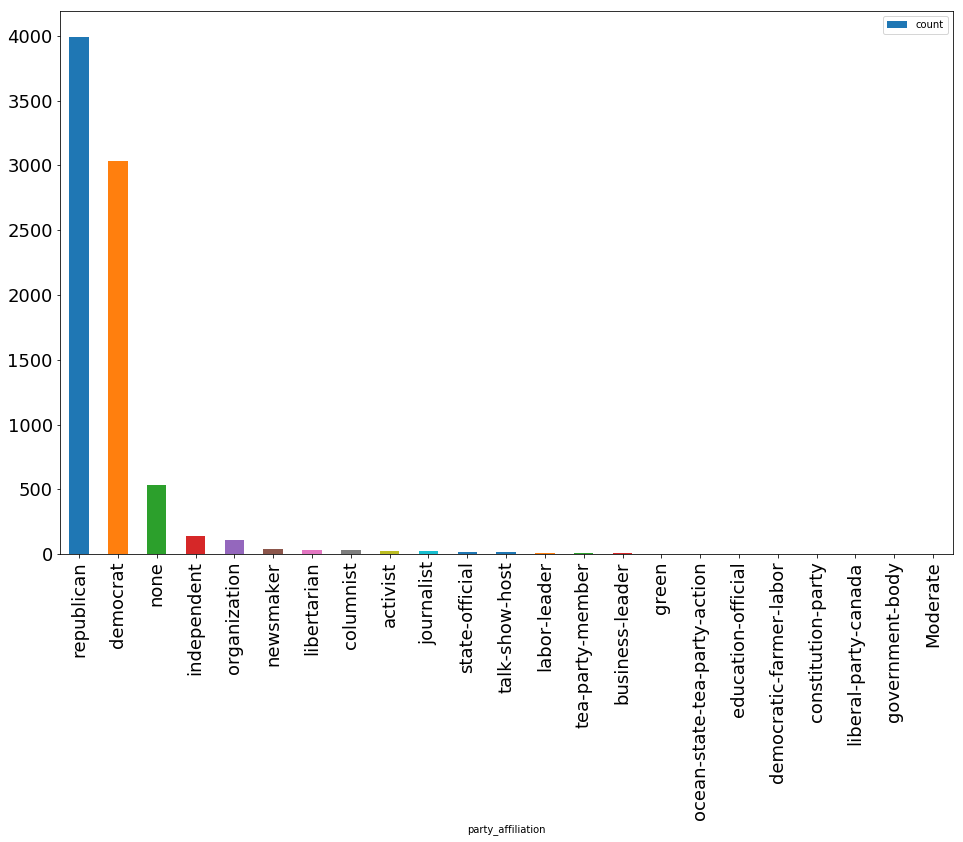

In [32]:
dataTrainPar.groupby('party_affiliation').count()[['state_info']].rename(
    columns={'state_info': 'count'}).sort_values(
    'count', ascending=False).reset_index().plot.bar(
        x='party_affiliation', y='count', figsize=(16, 10), fontsize=18);

From the graph above, the three main parties republican, democrat and none constitute 90% of the dataset. 
We use only these three parties for political affiliation and ignore the rest of the parties

# Retaining only democrat, republican and none for bias calculation

In [33]:

rowsToRemove = ['Moderate', 'activist', 'business-leader', 'columnist', 'constitution-party', 'democratic-farmer-labor', 'education-official', 'government-body', 'green', 'independent', 'journalist', 'labor-leader', 'liberal-party-canada', 'libertarian', 'nan', 'newsmaker', 'ocean-state-tea-party-action', 'organization', 'state-official', 'talk-show-host', 'tea-party-member']

dataTrainPar = dataTrainPar[dataTrainPar.party_affiliation != 'Moderate']
dataTrainPar = dataTrainPar[dataTrainPar.party_affiliation != 'activist']
dataTrainPar = dataTrainPar[dataTrainPar.party_affiliation != 'business-leader']
dataTrainPar = dataTrainPar[dataTrainPar.party_affiliation != 'columnist']
dataTrainPar = dataTrainPar[dataTrainPar.party_affiliation != 'constitution-party']
dataTrainPar = dataTrainPar[dataTrainPar.party_affiliation != 'democratic-farmer-labor']
dataTrainPar = dataTrainPar[dataTrainPar.party_affiliation != 'education-official']
dataTrainPar = dataTrainPar[dataTrainPar.party_affiliation != 'government-body']
dataTrainPar = dataTrainPar[dataTrainPar.party_affiliation != 'green']
dataTrainPar = dataTrainPar[dataTrainPar.party_affiliation != 'independent']
dataTrainPar = dataTrainPar[dataTrainPar.party_affiliation != 'journalist']
dataTrainPar = dataTrainPar[dataTrainPar.party_affiliation != 'labor-leader']
dataTrainPar = dataTrainPar[dataTrainPar.party_affiliation != 'liberal-party-canada']
dataTrainPar = dataTrainPar[dataTrainPar.party_affiliation != 'libertarian']
dataTrainPar = dataTrainPar[dataTrainPar.party_affiliation != 'nan']
dataTrainPar = dataTrainPar[dataTrainPar.party_affiliation != 'newsmaker']
dataTrainPar = dataTrainPar[dataTrainPar.party_affiliation != 'ocean-state-tea-party-action']
dataTrainPar = dataTrainPar[dataTrainPar.party_affiliation != 'organization']
dataTrainPar = dataTrainPar[dataTrainPar.party_affiliation != 'state-official']
dataTrainPar = dataTrainPar[dataTrainPar.party_affiliation != 'talk-show-host']
dataTrainPar = dataTrainPar[dataTrainPar.party_affiliation != 'tea-party-member']


dataTestPar = dataTestPar[dataTestPar.party_affiliation != 'Moderate']
dataTestPar = dataTestPar[dataTestPar.party_affiliation != 'activist']
dataTestPar = dataTestPar[dataTestPar.party_affiliation != 'business-leader']
dataTestPar = dataTestPar[dataTestPar.party_affiliation != 'columnist']
dataTestPar = dataTestPar[dataTestPar.party_affiliation != 'constitution-party']
dataTestPar = dataTestPar[dataTestPar.party_affiliation != 'democratic-farmer-labor']
dataTestPar = dataTestPar[dataTestPar.party_affiliation != 'education-official']
dataTestPar = dataTestPar[dataTestPar.party_affiliation != 'government-body']
dataTestPar = dataTestPar[dataTestPar.party_affiliation != 'green']
dataTestPar = dataTestPar[dataTestPar.party_affiliation != 'independent']
dataTestPar = dataTestPar[dataTestPar.party_affiliation != 'journalist']
dataTestPar = dataTestPar[dataTestPar.party_affiliation != 'labor-leader']
dataTestPar = dataTestPar[dataTestPar.party_affiliation != 'liberal-party-canada']
dataTestPar = dataTestPar[dataTestPar.party_affiliation != 'libertarian']
dataTestPar = dataTestPar[dataTestPar.party_affiliation != 'nan']
dataTestPar = dataTestPar[dataTestPar.party_affiliation != 'newsmaker']
dataTestPar = dataTestPar[dataTestPar.party_affiliation != 'ocean-state-tea-party-action']
dataTestPar = dataTestPar[dataTestPar.party_affiliation != 'organization']
dataTestPar = dataTestPar[dataTestPar.party_affiliation != 'state-official']
dataTestPar = dataTestPar[dataTestPar.party_affiliation != 'talk-show-host']
dataTestPar = dataTestPar[dataTestPar.party_affiliation != 'tea-party-member']
dataTrainPar.tail()
dataTestPar.tail()

,label,statement,subject,state_info,party_affiliation
1261,false,Sen. Bob Menendez voted to enact a new tax on ...,"health-care,housing,income,taxes",NaN,none
1262,true,Says his budget provides the highest state fun...,education,Florida,republican
1263,false,Ive been here almost every day.,"civil-rights,crime,criminal-justice",Missouri,democrat
1265,false,Says an EPA permit languished under Strickland...,"environment,government-efficiency",Ohio,republican
1266,false,Says the governor is going around the state ta...,"state-budget,state-finances,taxes",NaN,democrat


# After removing other non significant parties

In [34]:
dataTrainPar.party_affiliation.unique()

array(['republican', 'democrat', 'none', nan], dtype=object)

In [35]:
dataTrainPar['party_str'] = dataTrainPar['party_affiliation'].astype(str)
dataTestPar['party_str'] = dataTestPar['party_affiliation'].astype(str)

# Calculating LDA for Topic modeling

In [36]:
        doc_complete = dataTrainPar['statement'][:10]
        print(doc_complete)
        doc_clean = [clean(doc).split() for doc in doc_complete]
        print(doc_clean)
        
        #Preparing a document term matrix
        # Creating the term dictionary of our corpus, where every unique term is assigned an index. 
        dictionary = corpora.Dictionary(doc_clean)

        # Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
        doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]
        
        #Genarate an LDA Model
        
        
        # Creating the object for LDA model using gensim library
        Lda = gensim.models.ldamodel.LdaModel

        # Running and Trainign LDA model on the document term matrix.
        ldamodel = Lda(doc_term_matrix, num_topics=3, id2word = dictionary, passes=50)
        
        print(ldamodel.print_topics(num_topics=3, num_words=3))

        
        

0     Says the Annies List political group supports ...
1     When did the decline of coal start? It started...
2     Hillary Clinton agrees with John McCain "by vo...
3     Health care reform legislation is likely to ma...
4     The economic turnaround started at the end of ...
5     The Chicago Bears have had more starting quart...
6     Jim Dunnam has not lived in the district he re...
7     I'm the only person on this stage who has work...
9     Says GOP primary opponents Glenn Grothman and ...
10    For the first time in history, the share of th...
Name: statement, dtype: object
[['say', 'annies', 'list', 'political', 'group', 'support', 'thirdtrimester', 'abortion', 'demand'], ['decline', 'coal', 'start', 'started', 'natural', 'gas', 'took', 'started', 'begin', 'president', 'george', 'w', 'bush', 'administration'], ['hillary', 'clinton', 'agrees', 'john', 'mccain', 'by', 'voting', 'give', 'george', 'bush', 'benefit', 'doubt', 'iran'], ['health', 'care', 'reform', 'legislation', '

# Using Porter Stemmer, Word Net Lemmatizer and calculate TF-IDF values to obtain features

In [37]:
        ps = PorterStemmer()
        wn = nltk.WordNetLemmatizer()
        vectstem = TfidfVectorizer(analyzer=clean_stem)
        vectlemm = TfidfVectorizer(analyzer=clean_lemma)

        textfeatures=vectstem.fit_transform(dataTrainPar['statement'].values)
        print("Stemmed - " + str(len(vectstem.get_feature_names())))

        vectlemm.fit_transform(dataTrainPar['statement'].values)
        print("Lemmatized - " + str(len(vectlemm.get_feature_names())))
        
        print(pd.DataFrame(textfeatures.toarray()).head(15))
        
        textmatrix = pd.DataFrame(textfeatures.toarray(),columns=vectstem.vocabulary_)
        print(textmatrix.head(5))
        
        sum_scores = pd.DataFrame(textmatrix.sum(),columns=['sum_scores_TFIDF'])
        print(sum_scores.head(10))
        
        
        # Need to see most important words in the statements
        # words used by many people or less frequent in sentences
        print(sum_scores.sort_values(by='sum_scores_TFIDF',ascending=True)[:5])
        
        #high usage of words in statements
        
        print(sum_scores.sort_values(by='sum_scores_TFIDF',ascending=False)[:5])

Stemmed - 9120
Lemmatized - 11350
        0     1     2     3     4     5     6     7     8     9     ...   \
0   0.000000   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...    
1   0.000000   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...    
2   0.000000   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...    
3   0.000000   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...    
4   0.000000   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...    
5   0.000000   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...    
6   0.000000   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...    
7   0.000000   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...    
8   0.000000   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...    
9   0.000000   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...    
10  0.000000   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...    
11  0.000000   0.0   0.0   0.0   0.0   0.0   0.0   0.0

# Predicting truth level

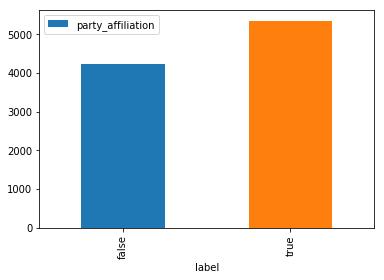

In [38]:

dataTrainPar.groupby('label').count()[['party_affiliation']].reset_index().plot.bar(x='label', y='party_affiliation')

# Democrat most used words

In [39]:

#
countDemV = CountVectorizer(stop_words='english', min_df=40, max_df=80, token_pattern=u'(?ui)\\b\\w*[a-z]+\\w*\\b')
#dataTrainDem = dataTrainPar[dataTrainPar['party_str'] != 'republican']
#dataTrainDem = dataTrainPar[dataTrainPar['party_str'] != 'none']
dataTrainDem= dataTrainPar
dataTrainDem = dataTrainPar.loc[dataTrainPar['party_str'] == 'democrat']
dem_count = countDemV.fit_transform(dataTrainDem['statement'].values)

#dataTestDem = dataTestPar[dataTestPar.party_affiliation != 'republican']
#dataTestDem = dataTestPar[dataTestPar.party_affiliation != 'none']

dataTestDem= dataTestPar
dataTestDem = dataTestPar.loc[dataTestPar['party_str'] == 'democrat']


print('Democrat most used words')
print(countDemV.get_feature_names())
dataTrainDem.tail()



Democrat most used words
['act', 'actually', 'administration', 'america', 'americans', 'barack', 'bush', 'campaign', 'candidate', 'city', 'class', 'clinton', 'college', 'companies', 'congress', 'cost', 'costs', 'county', 'created', 'cuts', 'day', 'debt', 'deficit', 'did', 'dollars', 'donald', 'dont', 'economy', 'education', 'families', 'florida', 'funding', 'going', 'government', 'governor', 'gun', 'half', 'higher', 'highest', 'history', 'house', 'income', 'job', 'john', 'just', 'like', 'make', 'mccain', 'medicare', 'middle', 'mitt', 'months', 'nation', 'national', 'nearly', 'number', 'office', 'paid', 'passed', 'private', 'program', 'public', 'rates', 'reform', 'rep', 'republicans', 'rhode', 'rick', 'right', 'romney', 'school', 'schools', 'security', 'sen', 'senate', 'single', 'social', 'spending', 'support', 't', 'times', 'today', 'took', 'trump', 'unemployment', 'vote', 'walker', 'wants', 'weve', 'world']


,label,statement,subject,state_info,party_affiliation,party_str
10220,true,Says he and Mitt Romney agreed on tying minimu...,"poverty,workers",Illinois,democrat,democrat
10224,false,"In 2012, the state put together a list of over...",elections,Florida,democrat,democrat
10233,false,Mayor Fung wants to punish our childrens educa...,"children,city-budget,deficit,education,state-b...",Rhode Island,democrat,democrat
10234,true,"Under the ruling of the Supreme Court, any lob...","corporations,elections",NaN,democrat,democrat
10238,false,On lifting the U.S. Cuban embargo and allowing...,"florida,foreign-policy",Florida,democrat,democrat


# Republican most used words

In [40]:

countRepV = CountVectorizer(stop_words='english', min_df=20, max_df=40, token_pattern=u'(?ui)\\b\\w*[a-z]+\\w*\\b')
#dataTrainRep = dataTrainPar[dataTrainPar.party_affiliation != 'democrat']
#dataTrainRep = dataTrainPar[dataTrainPar.party_affiliation != 'none']
dataTrainRep= dataTrainPar
dataTrainRep = dataTrainPar.loc[dataTrainPar['party_str'] == 'republican']
rep_count = countRepV.fit_transform(dataTrainRep['statement'].values)


#dataTestRep = dataTestPar[dataTestPar.party_affiliation != 'democrat']
#dataTestRep = dataTestPar[dataTestPar.party_affiliation != 'none']
dataTestRep = dataTrainPar.loc[dataTrainPar['party_str'] == 'republican']
#print('Republican most used words')
dataTrainRep.tail()
#print(countRepV.get_feature_names())


,label,statement,subject,state_info,party_affiliation,party_str
10230,false,The Supreme Courts views are radically out of ...,"gays-and-lesbians,polls,supreme-court",Texas,republican,republican
10231,true,"When it comes to the state deficit, Wisconsin ...",state-budget,Wisconsin,republican,republican
10236,true,Democrats have now become the party of the [At...,elections,Georgia,republican,republican
10237,true,Says an alternative to Social Security that op...,"retirement,social-security",Georgia,republican,republican
10239,false,The Department of Veterans Affairs has a manua...,"health-care,veterans",Maryland,republican,republican


# Party Affiliation from the headline
lets compare the headlines with these tokens. If the headlines match with the demoracratic tokens
and if tha party is democratic, then we assign true else false. If the headlines match with 
republican tokens and their party affiliation is republic we assign true else false.
for party_affiliation none, we assign true all the time

In [41]:


def partyAffiliationFromHeadline(r):
    v = r['subject_str']
    p = r['party_str']
    if (p =='democrat'):
        s2 = set(countDemV.get_feature_names())
    if (p =='republican'):
        s2 = set(countRepV.get_feature_names())
    if (p != 'democract' and p !='republican'):
        return 'true'        
    if set(v).intersection(s2):
        return 'true'
    else:
        return 'false'

dataTrainPar['subject_str'] = dataTrainPar['subject'].astype(str).str.split() 
#dataTrainPar['party_str'] = dataTrainPar['party_affiliation'].astype(str)
dataTrainPar['label_str'] = dataTrainPar.apply(partyAffiliationFromHeadline, axis=1)

dataTestPar['subject_str'] = dataTestPar['subject'].astype(str).str.split() 
#dataTrainPar['party_str'] = dataTrainPar['party_affiliation'].astype(str)
dataTestPar['label_str'] = dataTestPar.apply(partyAffiliationFromHeadline, axis=1)

dataTrainDem['subject_str'] = dataTrainDem['subject'].astype(str).str.split() 
#dataTrainDem['party_str'] = dataTrainDem['party_affiliation'].astype(str)
dataTrainDem['label_str'] = dataTrainDem.apply(partyAffiliationFromHeadline, axis=1)

dataTrainRep['subject_str'] = dataTrainRep['subject'].astype(str).str.split() 
#dataTrainRep['party_str'] = dataTrainRep['party_affiliation'].astype(str)
dataTrainRep['label_str'] = dataTrainRep.apply(partyAffiliationFromHeadline, axis=1)

dataTestDem['subject_str'] = dataTestDem['subject'].astype(str).str.split() 
#dataTestDem['party_str'] = dataTestDem['party_affiliation'].astype(str)
dataTestDem['label_str'] = dataTestDem.apply(partyAffiliationFromHeadline, axis=1)

dataTestRep['subject_str'] = dataTestRep['subject'].astype(str).str.split() 
#dataTestRep['party_str'] = dataTestRep['party_affiliation'].astype(str)
dataTestRep['label_str'] = dataTestRep.apply(partyAffiliationFromHeadline, axis=1)

dataTrainPar.tail()

/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-vers

,label,statement,subject,state_info,party_affiliation,party_str,subject_str,label_str
10235,true,There are a larger number of shark attacks in ...,"animals,elections",Florida,none,none,"[animals,elections]",true
10236,true,Democrats have now become the party of the [At...,elections,Georgia,republican,republican,[elections],true
10237,true,Says an alternative to Social Security that op...,"retirement,social-security",Georgia,republican,republican,"[retirement,social-security]",false
10238,false,On lifting the U.S. Cuban embargo and allowing...,"florida,foreign-policy",Florida,democrat,democrat,"[florida,foreign-policy]",true
10239,false,The Department of Veterans Affairs has a manua...,"health-care,veterans",Maryland,republican,republican,"[health-care,veterans]",false


In [42]:
dataTrainDem.label.unique()

array(['true', 'false'], dtype=object)

In [43]:
dataTrainRep.label_str.unique()

array(['true', 'false'], dtype=object)

In [44]:
dataTrainDem.label_str.unique()

array(['true'], dtype=object)

In [45]:
dataTrainDem.tail()

,label,statement,subject,state_info,party_affiliation,party_str,subject_str,label_str
10220,true,Says he and Mitt Romney agreed on tying minimu...,"poverty,workers",Illinois,democrat,democrat,"[poverty,workers]",true
10224,false,"In 2012, the state put together a list of over...",elections,Florida,democrat,democrat,[elections],true
10233,false,Mayor Fung wants to punish our childrens educa...,"children,city-budget,deficit,education,state-b...",Rhode Island,democrat,democrat,"[children,city-budget,deficit,education,state-...",true
10234,true,"Under the ruling of the Supreme Court, any lob...","corporations,elections",NaN,democrat,democrat,"[corporations,elections]",true
10238,false,On lifting the U.S. Cuban embargo and allowing...,"florida,foreign-policy",Florida,democrat,democrat,"[florida,foreign-policy]",true


In [46]:
dataTrainRep.tail()

,label,statement,subject,state_info,party_affiliation,party_str,subject_str,label_str
10230,false,The Supreme Courts views are radically out of ...,"gays-and-lesbians,polls,supreme-court",Texas,republican,republican,"[gays-and-lesbians,polls,supreme-court]",false
10231,true,"When it comes to the state deficit, Wisconsin ...",state-budget,Wisconsin,republican,republican,[state-budget],false
10236,true,Democrats have now become the party of the [At...,elections,Georgia,republican,republican,[elections],true
10237,true,Says an alternative to Social Security that op...,"retirement,social-security",Georgia,republican,republican,"[retirement,social-security]",false
10239,false,The Department of Veterans Affairs has a manua...,"health-care,veterans",Maryland,republican,republican,"[health-care,veterans]",false


# Now we can classify based on the training set 

accuracy:   0.805
Confusion matrix, without normalization


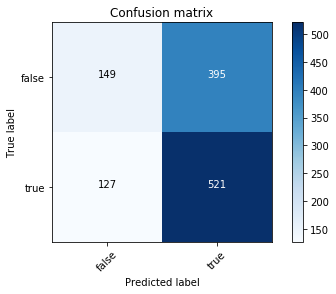

In [47]:


import numpy as np
import pandas as pd
import pickle
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import  LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import KFold
from sklearn.metrics import confusion_matrix, f1_score, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

#building classifier using naive bayes for countVectorizer
nb_pipeline = Pipeline([
        ('NV',countDemV),
        ('n_clf',MultinomialNB())])

dataTrainDem.dropna()
dataTrainDem.dropna(axis=0, how='any')
dataTestDem.dropna(axis=0, how='any')
dataTrainDem = dataTrainDem[pd.notnull(dataTrainDem['party_str'])]
dataTrainDem.tail()
nb_pipeline.fit(dataTrainPar['statement'], dataTrainPar['label_str'])
predicted_nb = nb_pipeline.predict(dataTestPar['statement'])
np.mean(predicted_nb == dataTestPar['label_str'])

#calcuated the accuracy
score = metrics.accuracy_score(dataTestPar['label_str'], predicted_nb)
score = score + scores
print("accuracy:   %0.3f" % score)

# genrating confusion matrix
cm = metrics.confusion_matrix(dataTestPar['label_str'], predicted_nb, labels=['false', 'true'])
plot_confusion_matrix(cm, classes=['false', 'true'])

# Logistic regression with TFIDF

In [48]:

logR_pipeline = Pipeline([
        ('LogRCV', tfidfV),
        ('LogR_clf',LogisticRegression())
        ])

logR_pipeline.fit(dataTrainPar['statement'],dataTrainPar['label_str'])
predicted_LogR = logR_pipeline.predict(dataTestPar['statement'])


accuracy:   0.834
Confusion matrix, without normalization


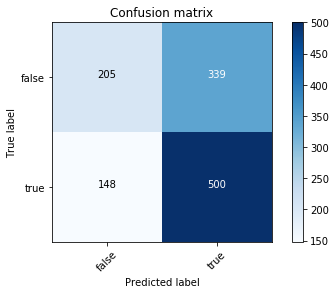

In [49]:
score = metrics.accuracy_score(dataTestPar['label_str'], predicted_LogR)
score = score + scores
print("accuracy:   %0.3f" % score)

cm = metrics.confusion_matrix(dataTestPar['label_str'], predicted_LogR, labels=['false', 'true'])
plot_confusion_matrix(cm, classes=['false', 'true'])

# Linear SVM classfier with count vectorizer

In [50]:

svm_pipeline = Pipeline([
        ('svmCV',countV),
        ('svm_clf',svm.LinearSVC())
        ])

svm_pipeline.fit(dataTrainPar['statement'],dataTrainPar['label_str'])
predicted_svm = svm_pipeline.predict(dataTestPar['statement'])


accuracy:   0.810
Confusion matrix, without normalization


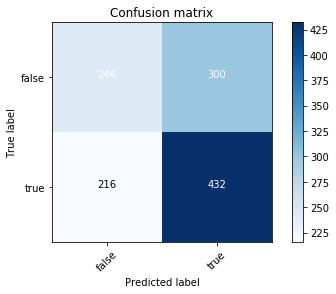

In [51]:
# calculate accuracy
score = metrics.accuracy_score(dataTestPar['label_str'], predicted_svm)
score = score + scores
print("accuracy:   %0.3f" % score)

#plot confusion matrix
cm = metrics.confusion_matrix(dataTestPar['label_str'], predicted_svm, labels=['false', 'true'])
plot_confusion_matrix(cm, classes=['false', 'true'])

# Random Forest classfier with  count vectorizer

In [52]:

random_forest = Pipeline([
        ('rfCV', countDemV),
        ('rf_clf',RandomForestClassifier(n_estimators=200,n_jobs=3))
        ])
    
random_forest.fit(dataTrainPar['statement'],dataTrainPar['label_str'])
predicted_rf = random_forest.predict(dataTestPar['statement'])


accuracy:   0.810
Confusion matrix, without normalization


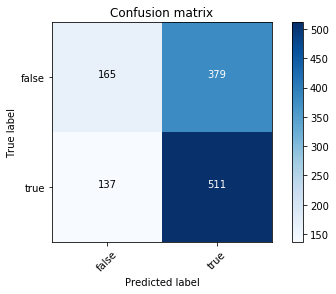

In [53]:
#calculate accuracy
score = metrics.accuracy_score(dataTestPar['label_str'], predicted_rf)
score = score + scores
print("accuracy:   %0.3f" % score)

#plot confusion matrix
cm = metrics.confusion_matrix(dataTestPar['label_str'], predicted_rf, labels=['false', 'true'])
plot_confusion_matrix(cm, classes=['false', 'true'])

# Logistic regression with TF-IDF gave 83.4% accuracy for Party Affiliation